# Réseau de neurones dense

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style = "darkgrid", palette = "colorblind")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

from joblib import dump, load # pour enregistrer et charger les modèles.
#from IPython.display import display_html # pour pouvoir afficher deux df côte à côte.

from tensorflow.keras.layers import Input, Dense #Pour instancier une couche Dense et une d'Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision
from tensorflow.keras.optimizers import Adam
n_coeurs = 4

In [2]:
#### Callbacks:

#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
early_stopping = EarlyStopping(monitor = 'val_loss', 
                               min_delta = 0.0001,  # arrête si le changement est inférieur est min_delta
                               patience = 5,
                               mode = 'min', # In min mode, training will stop when the quantity monitored has stopped decreasing
                               restore_best_weights = True,
                               verbose = 1)

#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', 
                              min_delta = 0.0001, 
                              patience = 3, 
                              factor = 0.1, 
                              mode = 'min',
                              cooldown = 4, 
                              verbose = 1)

In [3]:
# Instanciation df
df = pd.read_csv('../../data/processed/model_weatherAUS.csv')
df.drop(columns = 'Unnamed: 0', inplace = True)
df['Date'] = pd.to_datetime(df['Date'])

###### Proportions initiales target:
#RainTomorrow
#0    0.778382
#1    0.221618

# Séparation data / target:
X = df.drop(columns = ['RainTomorrow', 'Date']).copy()
#X = df[[Pressure9am, Pressure3pm, WindGU]].copy()
y = df['RainTomorrow'].copy()

# Séparation du jeu d'entrainement et du jeu de test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123, stratify = y)

# Scale de X_train, X_test:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


C:\Users\AlexW\anaconda3\envs\TestDL\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\AlexW\anaconda3\envs\TestDL\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\AlexW\anaconda3\envs\TestDL\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\AlexW\anaconda3\envs\TestDL\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check 

In [4]:
inputs = Input(shape = (28), name = 'Input') # il y a 28 variables explicatives

dense1 = Dense(units = 16, activation = 'relu', name = 'Dense_1') # https://www.tensorflow.org/api_docs/python/tf/keras/activations
dense2 = Dense(units = 8, activation = 'relu', name = 'Dense_2')
dense3 = Dense(units = 4, activation = 'relu', name = 'Dense_3')
dense4 = Dense(units = 1, activation = 'sigmoid', name = 'Dense_4') 

x = dense1(inputs)
x = dense2(x)
x = dense3(x)
outputs = dense4(x)

model = Model(inputs = inputs, outputs = outputs)

opt = Adam(learning_rate = 0.00001)
model.compile(loss = 'binary_crossentropy',      # https://www.tensorflow.org/api_docs/python/tf/keras/losses
              optimizer = opt,               # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
              metrics = ['accuracy'])          # https://www.tensorflow.org/api_docs/python/tf/keras/metrics
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 28)]              0         
                                                                 
 Dense_1 (Dense)             (None, 16)                464       
                                                                 
 Dense_2 (Dense)             (None, 8)                 136       
                                                                 
 Dense_3 (Dense)             (None, 4)                 36        
                                                                 
 Dense_4 (Dense)             (None, 1)                 5         
                                                                 
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________


In [25]:
model_history = model.fit(X_train, y_train, epochs = 100, batch_size = 32, validation_split = 0.2, callbacks = [early_stopping, reduce_lr])

Epoch 1/100
2640/2640 [==============================] - 4s 1ms/step - loss: 0.6459 - accuracy: 0.7044 - val_loss: 0.6151 - val_accuracy: 0.7628 - lr: 1.0000e-05
Epoch 2/100
2640/2640 [==============================] - 3s 1ms/step - loss: 0.5874 - accuracy: 0.7839 - val_loss: 0.5623 - val_accuracy: 0.7928 - lr: 1.0000e-05
Epoch 3/100
2640/2640 [==============================] - 3s 1ms/step - loss: 0.5378 - accuracy: 0.7978 - val_loss: 0.5177 - val_accuracy: 0.7989 - lr: 1.0000e-05
Epoch 4/100
2640/2640 [==============================] - 3s 1ms/step - loss: 0.4971 - accuracy: 0.8045 - val_loss: 0.4825 - val_accuracy: 0.8047 - lr: 1.0000e-05
Epoch 5/100
2640/2640 [==============================] - 3s 1ms/step - loss: 0.4655 - accuracy: 0.8103 - val_loss: 0.4560 - val_accuracy: 0.8101 - lr: 1.0000e-05
Epoch 6/100
2640/2640 [==============================] - 3s 1ms/step - loss: 0.4421 - accuracy: 0.8158 - val_loss: 0.4372 - val_accuracy: 0.8140 - lr: 1.0000e-05
Epoch 7/100
2640/2640 [=====

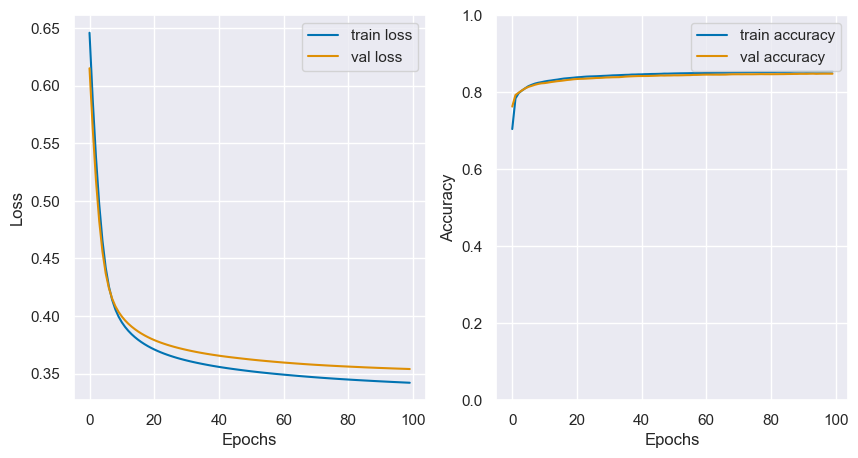

In [26]:
plt.figure(figsize = (10, 5))
plt.subplot(121)
plt.plot(model_history.history['loss'], label = 'train loss')
plt.plot(model_history.history['val_loss'], label = 'val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim([0,1])
plt.legend()

plt.subplot(122)
plt.plot(model_history.history['accuracy'], label = 'train accuracy')
plt.plot(model_history.history['val_accuracy'], label = 'val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.legend()

plt.show()

In [27]:
test_pred = model.predict(X_test)
y_pred_class = [round(test_pred[i, 0],0) for i in range(test_pred.shape[0]) ]
print(classification_report(y_test,y_pred_class))
print(confusion_matrix(y_test,y_pred_class))

1100/1100 [==============================] - 1s 683us/step
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     27397
           1       0.73      0.54      0.62      7800

    accuracy                           0.85     35197
   macro avg       0.80      0.74      0.76     35197
weighted avg       0.84      0.85      0.84     35197

[[25838  1559]
 [ 3614  4186]]


C:\Users\AlexW\anaconda3\envs\TestDL\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\AlexW\anaconda3\envs\TestDL\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\AlexW\anaconda3\envs\TestDL\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\AlexW\anaconda3\envs\TestDL\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if